# Problem

Download the 'airline-passengers.csv'

In the given problem our task is to predict the number of passengers.

Our data consist of 144 observations between 1949 and 1960 (passengers / month)

In [1]:
import pandas
import matplotlib.pyplot as plt

In [2]:
data = pandas.read_csv('airline-passengers.csv')
data.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


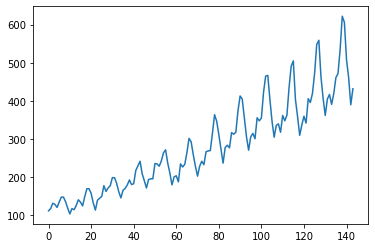

In [3]:
df = pandas.read_csv('airline-passengers.csv', usecols=[1]) #we will skip the column of the year/month which is column[0]
plt.plot(df)
plt.show()

One good technique is to always plot some or all of your data. That way you will get a rough idea of your data, trending and periodically behavior.

In this first example we will keep our data as they are. A good technique is always do a data preparation rescaling your data and make them stationary. We wiil see these techniques in later examples.

# Long Short-Term Memory Network

Instead of neurons, LSTM networks have memory blocks that are connected through layers

 - A block has components that make it smarter than a classical neuron and a memory for recent sequences. 

 - A block contains gates that manage the block’s state and output. 
 
 - A block operates upon an input sequence and each gate within a block uses the sigmoid activation units to control whether they are triggered or not, making the change of state and addition of information flowing through the block conditional.

There are three types of gates within a unit:

 - Forget Gate: conditionally decides what information to throw away from the block.
 
 - Input Gate: conditionally decides which values from the input to update the memory state.
 
 - Output Gate: conditionally decides what to output based on input and the memory of the block.
 
Each unit is like a mini-state machine where the gates of the units have weights that are learned during the training procedure.

You can see how you may achieve sophisticated learning and memory from a layer of LSTMs, and it is not hard to imagine how higher-order abstractions may be layered with multiple such layers.

# # LSTM Network for Regression using Window Method

We can also phrase the problem so that multiple, recent time steps can be used to make the prediction for the next time step.

This is called a window, and the size of the window is a parameter that can be tuned for each problem.

For example, given the current time (t) we want to predict the value at the next time in the sequence (t+1), we can use the current time (t), as well as the two prior times (t-1 and t-2) as input variables.

When phrased as a regression problem, the input variables are t-2, t-1, t and the output variable is t+1.

The create_dataset() function we created in the previous section allows us to create this formulation of the time series problem by increasing the look_back argument from 1 to 3.

A sample of the dataset with this formulation looks as follows:

X1	X2	X3	Y
112	118	132	129
118	132	129	121
132	129	121	135
129	121	135	148
121	135	148	148

In [4]:
#Import all the required modules, classes and functions
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [5]:
# fix random seed for reproducibility (https://machinelearningmastery.com/reproducible-results-neural-networks-keras/)
numpy.random.seed(7)

In [6]:
dataset = df.values #get values as nparrays
dataset = dataset.astype("float32") #convert values to floating points which are better for modelling

LSTMs are sensitive to the scale of input data due to the reason that sigmoid or tanh activation function are used.

A good technique is to rescale the data between 0 and 1, a procedure known as normalizing.

'scikit-learn' library can help us with the preprocessing class called MinMaxScaler.

In [7]:
#normalize the data

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

 A simple method that we can use is to split the ordered dataset into train and test datasets.
 That way we can train our model with the train data and then test the model using the unseen test data.

In [8]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:] #slicing out data
print(len(train), len(test))

96 48


Let's make a function where we insert a numpy array and the number of previous time steps to use as input variables to predict the next time period.
We will use a default of 1 hour meaning that our X is the number of passengers at a given time (t) and Y the passengers at the next time (t+1).

In [9]:
def create_dataset(dataset,look_back=1): #we can set look_back as we want (here is 1 hour)
    dataX , dataY = [], [] #create 2 empty lists
    for i in range(len(dataset)-look_back-1): #set the range of the loop, keep in mind what happends with the last item of a range and that we don't want the last item of x since is the prediction Y. 
        a = dataset[i:(i + look_back), 0] #dataset range for choosing one value of the first column[0] in a list
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0]) #dataset range for choosing one hour later value
    return numpy.array(dataX), numpy.array(dataY)

Imagine this:
X=t		Y=t+1
112		118
118		132
132		129
129		121
121		135

In [10]:
#Lets use our function
look_back = 3
trainX, trainY =create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

Up to now our data are in the form of samples(total values) and features(value for each observation) and we need to insert timesteps in order to be [samples,time steps,features]

In [11]:
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX= numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [12]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back))) #1 input and 4 hidden layers or neurons
model.add(Dense(1)) #single output
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
92/92 - 1s - loss: 0.0372
Epoch 2/100
92/92 - 0s - loss: 0.0145
Epoch 3/100
92/92 - 0s - loss: 0.0110
Epoch 4/100
92/92 - 0s - loss: 0.0096
Epoch 5/100
92/92 - 0s - loss: 0.0087
Epoch 6/100
92/92 - 0s - loss: 0.0076
Epoch 7/100
92/92 - 0s - loss: 0.0068
Epoch 8/100
92/92 - 0s - loss: 0.0063
Epoch 9/100
92/92 - 0s - loss: 0.0058
Epoch 10/100
92/92 - 0s - loss: 0.0055
Epoch 11/100
92/92 - 0s - loss: 0.0053
Epoch 12/100
92/92 - 0s - loss: 0.0050
Epoch 13/100
92/92 - 0s - loss: 0.0050
Epoch 14/100
92/92 - 0s - loss: 0.0047
Epoch 15/100
92/92 - 0s - loss: 0.0047
Epoch 16/100
92/92 - 0s - loss: 0.0046
Epoch 17/100
92/92 - 0s - loss: 0.0047
Epoch 18/100
92/92 - 0s - loss: 0.0045
Epoch 19/100
92/92 - 0s - loss: 0.0046
Epoch 20/100
92/92 - 0s - loss: 0.0044
Epoch 21/100
92/92 - 0s - loss: 0.0044
Epoch 22/100
92/92 - 0s - loss: 0.0042
Epoch 23/100
92/92 - 0s - loss: 0.0043
Epoch 24/100
92/92 - 0s - loss: 0.0041
Epoch 25/100
92/92 - 0s - loss: 0.0042
Epoch 26/100
92/92 - 0s - loss: 0.

In [13]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [14]:
# invert predictions so the values become as the original
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [15]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))


Train Score: 23.71 RMSE
Test Score: 62.09 RMSE


In [16]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

In [23]:
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

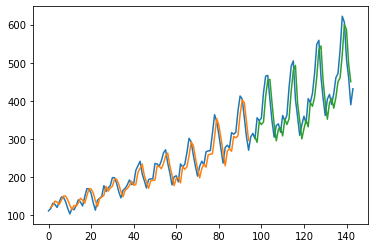

In [24]:
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()